### Imports

In [35]:
# System utilities
import sys
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL

# Tensorflow/Keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential,load_model # for assembling a Neural Network model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout, Embedding,Concatenate,ReLU,LeakyReLU,BatchNormalization
#from tensorflow.compat.v1.keras.layers import BatchNormalization
from keras.utils import plot_model # for plotting model diagram
from keras.optimizers import Adam # for model optimization 
#from tensorflow_docs.vis import embed
from keras.initializers import RandomNormal
print('Tensorflow: %s' % tf.__version__) # print version
print('Keras: %s' % keras.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Data manipulation
import numpy as np # for data manipulation
import sklearn
# Visualization
import imageio  # for ingesting images
import matplotlib.pyplot as plt # or data visualizationa
import graphviz # for showing model diagram

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

Tensorflow: 2.10.1
Keras: 2.10.0
Num GPUs Available:  1


### Constants and hyperparameters

In [36]:
batch_size = 128
dataset_name = 'cifar10'
num_channels = 3
image_size = 32
num_classes = 10
latent_dim = 100

### Load and preprocess dataset

Shape of X_train:  (60000, 32, 32, 3)
Shape of y_train:  (60000, 1)


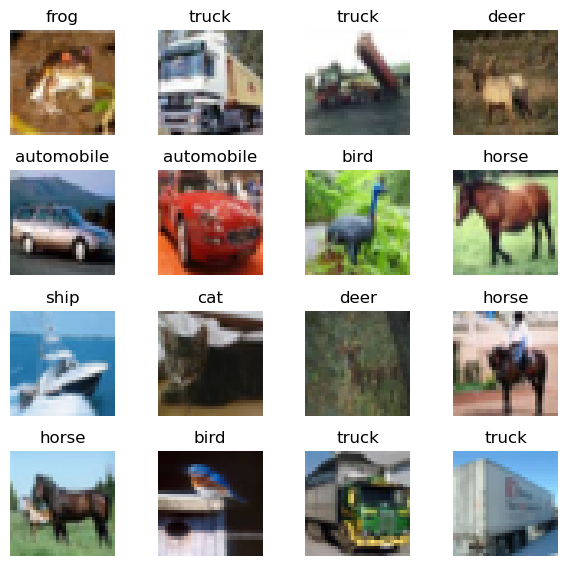

In [37]:
# Load MNIST dataset by default
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
if dataset_name == 'mnist':
    assert image_size == 28
    assert num_channels == 1
# FMNIST
elif dataset_name=='fmnist':
    assert image_size == 28
    assert num_channels == 1
    classes = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# CIFAR-10
elif dataset_name=='cifar10':
    assert image_size == 32
    assert num_channels == 3
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
else:
    raise NotImplementedError("No such dataset")
# Use all available examples from training and test set
X_train = np.concatenate([X_train, X_test])
y_train = np.concatenate([y_train, y_test])
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

# Display first 16 images in the training set and their true lables
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_train[i])
    plt.title(classes[y_train.flat[i]] )
    plt.tight_layout()
    plt.axis('off')
plt.show()

# Scale and reshape as required by the model
data=X_train.copy()
data=data.reshape(X_train.shape[0], image_size, image_size, num_channels)
data = (data - 127.5) / 127.5  # Normalize the images to [-1, 1]

### Create generator and discriminator

In [38]:
# weight initializer for G per DCGAN paper
#WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 

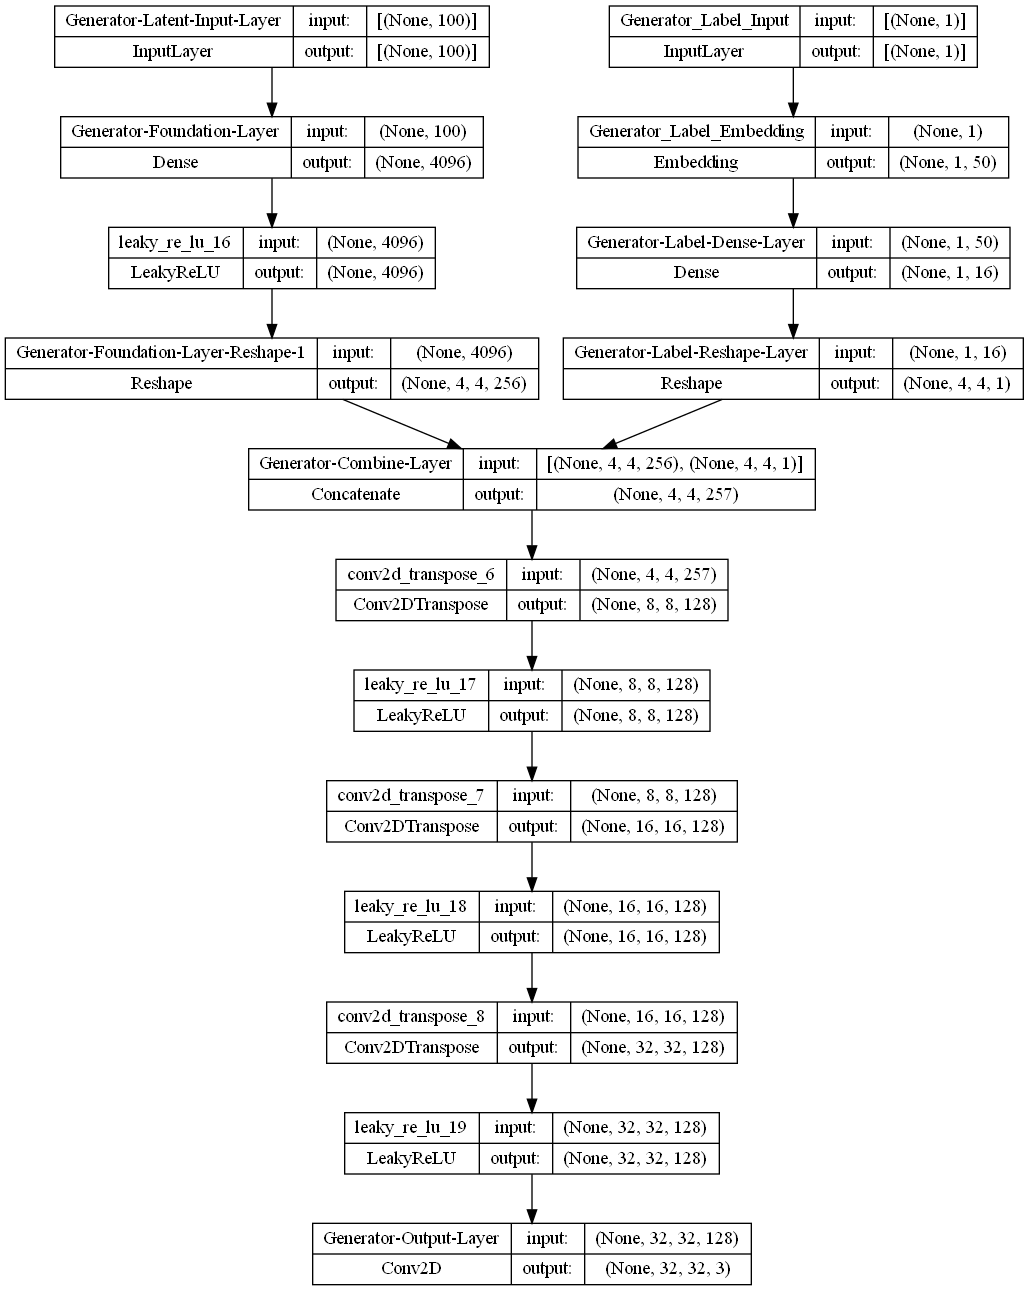

In [39]:
def generator(in_shape=(4,4,3), in_class=256,upsamplings=3, multnodes = 1.0, out_kernel=3):
    # Label inputs
    in_label = Input(shape=(1,), name='Generator_Label_Input')
    lbls = Embedding(num_classes, 50, name='Generator_Label_Embedding')(in_label)
    
    # Scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Generator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Generator-Label-Reshape-Layer')(lbls)

    # Generator input from latent vector
    in_latent = Input(shape=latent_dim, name='Generator-Latent-Input-Layer')
    
    # Image foundation
    n_nodes = in_shape[0] * in_shape[1] * in_class
    g = Dense(n_nodes, name='Generator-Foundation-Layer')(in_latent)
    g = LeakyReLU(alpha=0.2)(g)
    g = Reshape((in_shape[0], in_shape[1], in_class), name='Generator-Foundation-Layer-Reshape-1')(g)
    
    # Merge image and label
    concat = Concatenate(name='Generator-Combine-Layer')([g, lbls])

    nodeslayers = in_class
    for i in range(upsamplings):
        nodeslayers = nodeslayers * multnodes
        concat = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(concat)
        concat = LeakyReLU(alpha=0.2)(concat)

    # Output Layer
    output_layer = Conv2D(filters=in_shape[2], kernel_size=out_kernel, activation='tanh', padding='same', name='Generator-Output-Layer')(concat)
    
    # Define model
    model = Model([in_latent, in_label], output_layer, name='Generator')
    return model

# Instantiate generator
gen_model = generator(out_kernel=5) #cifar10
if dataset_name =="mnist" or dataset_name=='fmnist':
    gen_model = generator(in_shape=(7,7,1),in_class=128,upsamplings=2, out_kernel=7) #mnist

# Show model summary and plot model diagram
gen_model.summary()
plot_model(gen_model, show_shapes=True, to_file=main_dir+'/gan/models/{}_generator_arch.png'.format(dataset_name))

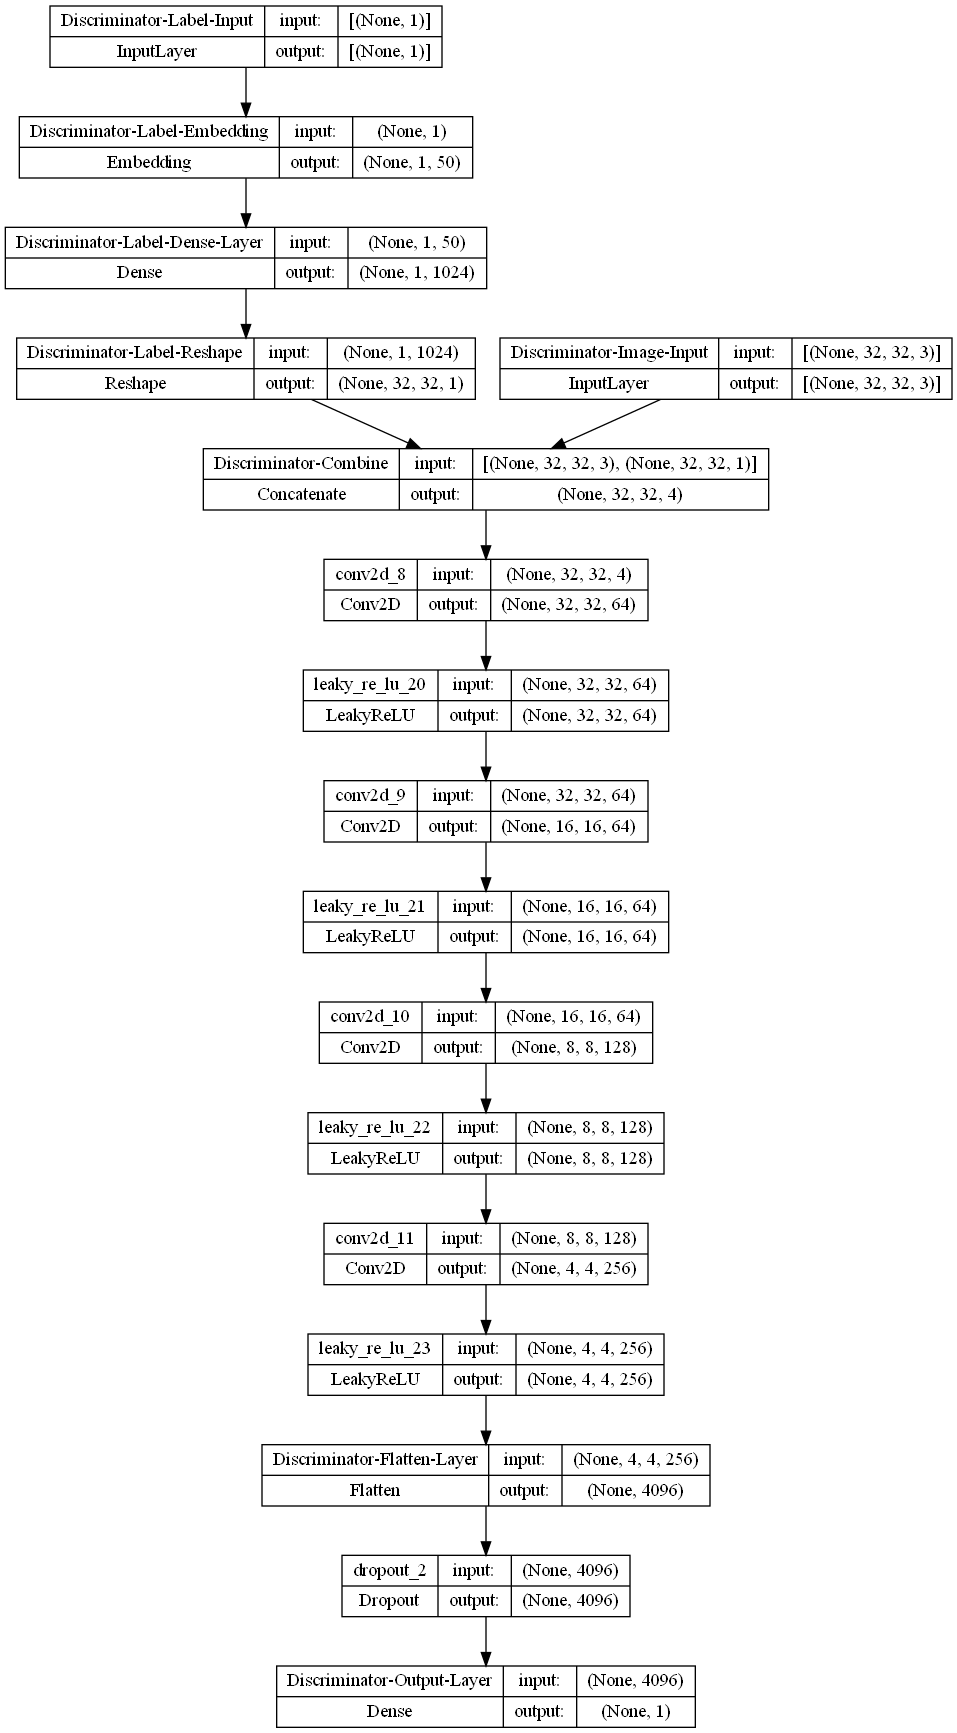

In [40]:
def discriminator(in_class=64, downsamples=3, multnodes = 2.0, in_shape=(32, 32, 3)):

    # Label Inputs
    in_label = Input(shape=(1,), name='Discriminator-Label-Input') # Input Layer
    lbls = Embedding(num_classes, 50, name='Discriminator-Label-Embedding')(in_label) # Embed label to vector
    
    # Scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Discriminator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Discriminator-Label-Reshape')(lbls) # New shape

    # Image Inputs
    in_image = Input(shape=in_shape, name='Discriminator-Image-Input')
    
    # Combine both inputs so it has two channels
    concat = Concatenate(name='Discriminator-Combine')([in_image, lbls])

    #normal
    h = Conv2D(in_class, (3,3), padding='same', input_shape=in_shape)(concat)
    h = LeakyReLU(alpha=0.2)(h)

    nodeslayers = in_class
    for i in range(downsamples):
        h = Conv2D(filters=nodeslayers, kernel_size=3, strides=2, padding='same')(h)
        h = LeakyReLU(alpha=0.2)(h)
        nodeslayers = nodeslayers * multnodes

    h = Flatten(name='Discriminator-Flatten-Layer')(h)
    h = Dropout(0.4)(h)
    output_layer = Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')(h)
    
    # Define model
    model = Model([in_image, in_label], output_layer, name='Discriminator')
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator() #cifar10
if dataset_name =="mnist" or dataset_name=='fmnist':
    dis_model = discriminator(in_class=128,downsamples=2,in_shape=(28,28,1),multnodes=1.0) #mnist

# Show model summary and plot model diagram
dis_model.summary()
plot_model(dis_model, show_shapes=True, to_file=main_dir+'/gan/models/{}_discriminator_arch.png'.format(dataset_name))

### Create Conditional GAN model

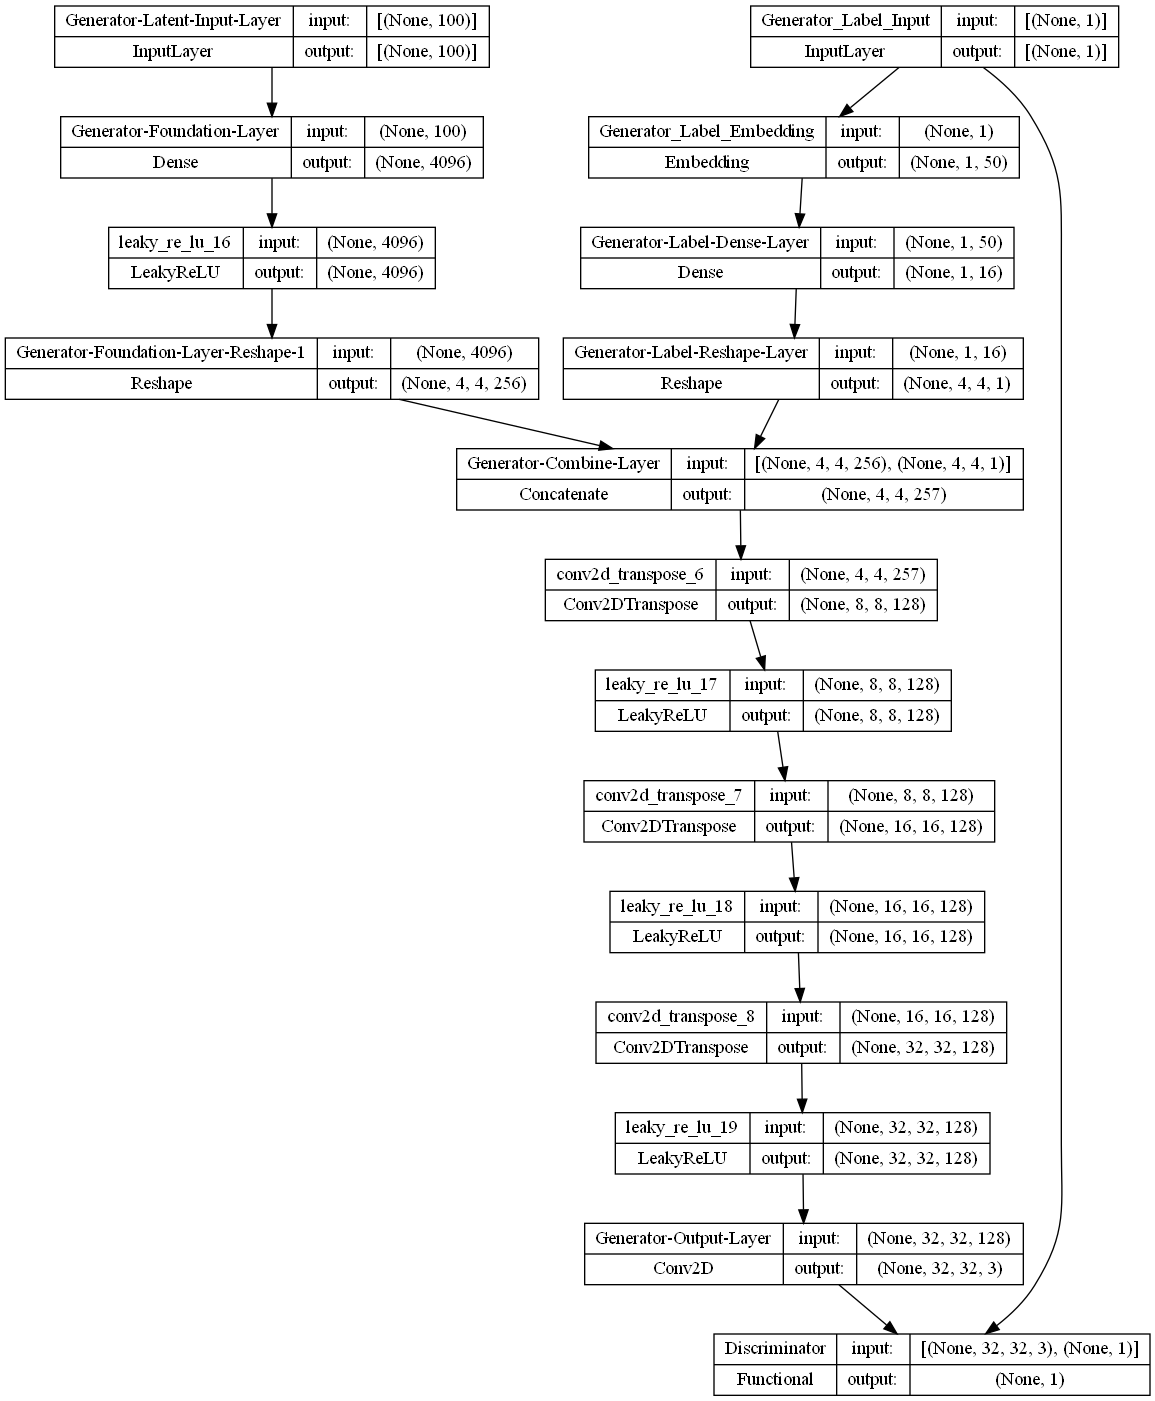

In [41]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Get Generator inputs / outputs
    gen_latent, gen_label = generator.input # Latent and label inputs from the generator
    gen_output = generator.output # Generator output image
    
    # Connect image and label from the generator to use as input into the discriminator
    gan_output = discriminator([gen_output, gen_label])
    
    # Define GAN model
    model = Model([gen_latent, gen_label], gan_output, name="cDCGAN")
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
plot_model(gan_model, show_shapes=True, to_file=main_dir+'/gan/models/{}_gan_arch.png'.format(dataset_name))

### Setup helper functions

In [42]:
# randomly flip some labels
# flip labels with 5% probability
def noisy_labels(y, p_flip=0.05):
	# determine the number of labels to flip
	n_select = int(p_flip * y.shape[0])
	# choose labels to flip
	flip_ix =np.random.choice([i for i in range(y.shape[0])], size=n_select)
	# invert the labels in place
	y[flip_ix] = 1 - y[flip_ix]
	return y

In [43]:
def smooth_positive(y):
  return y -0.2 + (np.random.random(y.shape) * 0.4)

def smooth_negative(y):
  return y + np.random.random(y.shape) * 0.3

In [44]:
def real_samples(dataset, categories, n):
    '''Sample real images'''
    # Create a random list of indices
    indx = np.random.randint(0, dataset.shape[0], n)
    
    # Select real data samples (images and category labels) using the list of random indeces from above
    X, cat_labels = dataset[indx], categories[indx]

    # Class labels
    y = np.ones((n, 1))

    return [X, cat_labels], y

In [45]:
def latent_vector(latent_dim, n, n_cats=10):
    '''Sample points in latent space for input to the generator'''
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    
    # Generate category labels 
    cat_labels = np.random.randint(0, n_cats, n)
    
    return [latent_input, cat_labels]

In [46]:
def fake_samples(generator, latent_dim, n):
    '''Generate fake samples with class labels using the generator'''
    # Generate points in latent space
    latent_output, cat_labels = latent_vector(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict([latent_output, cat_labels])
    
    # Create class labels
    y = np.zeros((n, 1))
    
    return [X, cat_labels], y

### Functions for CGAN evaluation and training

In [47]:
def save_plot(examples, epoch, n=5):
    """
    Create and save a plot of generated images
    """
    samples = (examples[0] + 1) / 2.0

    plt.figure(figsize=(6,6))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.imshow(samples[i])
        plt.title(classes[examples[1][i]])
        plt.axis('off')
        plt.tight_layout()
    filename = main_dir + '/gan/images/%s_plot_e%03d.png' % (dataset_name, epoch+1)
    plt.savefig(filename)
    #plt.show()
    plt.close()

In [48]:
def summarize_performance(epoch, g_model, d_model, data, latent_dim, n_samples=150):
    """
    Evaluate the discriminator, plot generated images, and save generator model
    """
    X_real, Y_real = real_samples(data,y_train, n_samples)
    _, acc_real = d_model.evaluate(X_real, Y_real, verbose=0)   # evaluate discriminator on real samples
    X_fake, Y_fake = fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(X_fake, Y_fake, verbose=0)   # evaluate discriminator on fake samples
    print('Accuracy> real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))    # summarize discriminator performance
    save_plot(X_fake, epoch)
    #filename = main_dir + '/gan/models/%s_gan_%03d.h5' % (dataset_name, epoch + 1)
    filename = main_dir + '/gan/models/%s_gan.h5' % (dataset_name)
    g_model.save(filename)

In [49]:
def train(g_model, d_model, gan_model, dataset, categories, n_epochs=10, n_eval=200):
    """Function to train the cDCGAN model (generator and discriminator)"""
    # Number of batches to use per each epoch
    batch_per_epoch = int(dataset.shape[0] / batch_size)
    print('batch_per_epoch: ',  batch_per_epoch)
    # The batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(batch_size / 2)
    
    # Manually enumerate epochs 
    for i in range(n_epochs):
        # Enumerate batches over the training set
        for j in range(batch_per_epoch):
            # Prep real samples
            [x_real, cat_labels_real], y_real = real_samples(dataset, categories, half_batch)
            # Prep fake samples
            [x_fake, cat_labels_fake], y_fake = fake_samples(g_model, latent_dim, half_batch)
            # Apply one-sided label smoothing to real labels
            #y_real = smooth_positive(y_real)
            # Apply one-sided label smoothing to real labels
            #y_fake = smooth_negative(y_fake)
            # Apply noise to labels
            y_real = noisy_labels(y_real)
            y_fake = noisy_labels(y_fake)
            # Train discriminator with real samples
            discriminator_loss1, _ = d_model.train_on_batch([x_real, cat_labels_real], y_real)
            # Train discriminator with fake samples
            discriminator_loss2, _ = d_model.train_on_batch([x_fake, cat_labels_fake], y_fake)
            # Get values from the latent space to be used as inputs for the generator
            [latent_input, cat_labels] = latent_vector(latent_dim, batch_size)
            # While we are generating fake samples, 
            # we want GAN generator model to create examples that resemble the real ones,
            # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
            #y_gan = smooth_positive(np.ones((batch_size, 1)))
            y_gan = np.ones((batch_size, 1))

            # Train the generator via a composite GAN model
            generator_loss = gan_model.train_on_batch([latent_input, cat_labels], y_gan)
        
            # Summarize training progress and loss on this batch
            if (j) % n_eval == 0:
                print('Epoch: %d, Batch: %d/%d, D_Loss_Real=%.3f, D_Loss_Fake=%.3f Gen_Loss=%.3f' % 
                      (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
                #show_fakes(g_model, latent_dim)
        # evaluate the model performance every 10 epochs
        #if (i+1) % 10 == 0: 
        summarize_performance(i, g_model, d_model, dataset, latent_dim)

### Train the model and display results

In [50]:
keras.utils.disable_interactive_logging()
# Train cDCGAN model
train(gen_model, dis_model, gan_model, data, y_train,n_epochs=500)

batch_per_epoch:  468
Epoch: 1, Batch: 1/468, D_Loss_Real=0.701, D_Loss_Fake=0.695 Gen_Loss=0.692
Epoch: 1, Batch: 201/468, D_Loss_Real=0.643, D_Loss_Fake=0.588 Gen_Loss=1.309
Epoch: 1, Batch: 401/468, D_Loss_Real=0.415, D_Loss_Fake=0.673 Gen_Loss=1.316
Accuracy> real: 69%, fake: 84%
Epoch: 2, Batch: 1/468, D_Loss_Real=0.633, D_Loss_Fake=0.501 Gen_Loss=1.415


KeyboardInterrupt: 

### Save model

In [ ]:
# We need to compile the generator to avoid a warning. This is because we have previously only copiled within the larger cDCGAN model
gen_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
# Save the Generator on your drive
gen_model.save(main_dir+'/gan/models/{}_gan.h5'.format(dataset_name))

### Generate images

In [ ]:
# Generate latent points
latent_points, _ = latent_vector(latent_dim, 100)

# Specify labels that we want (0-9 repeated 10 times)
labels = np.asarray([x for _ in range(10) for x in range(10)])
print(labels)

# Load previously saved generator model
model = load_model(main_dir+'/gan/models/{}_gan.h5'.format(dataset_name))

# Generate images
gen_imgs  = model.predict([latent_points, labels])

# Scale from [-1, 1] to [0, 1]
gen_imgs = (gen_imgs + 1) / 2.0

# Display images
# fig, axs = plt.subplots(10, 10, sharey=False, tight_layout=True, figsize=(16,16), facecolor='white')
# k=0
# for i in range(0,10):
#     for j in range(0,10):
#         axs[i,j].matshow(gen_imgs[k], cmap='gray')
#         axs[0,j].set(title=labels[k])
#         axs[i,j].axis('off')
#         k=k+1
# plt.show()

#********************************************************
labels = keras.utils.to_categorical(labels, 10)
dataset = tf.data.Dataset.from_tensor_slices((gen_imgs,labels))
dataset = dataset.shuffle(buffer_size=1024).batch(64)
plt.figure(figsize=(6, 6))
for images, labels in dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")
        plt.tight_layout()
plt.show()
#****************************************

# End of Program